# Predictive Analytics

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import pandas as pd
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import adam
import tensorflow as tf

from sklearn.preprocessing import StandardScaler, LabelBinarizer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Using TensorFlow backend.


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0'

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

## Neuronal Networks

Neural Networks are set of algorithms which closely resemble the human brain and are designed to recognize patterns. They interpret sensory data through a machine perception, labelling or clustering raw input. They can recognize numerical patterns, contained in vectors, into which all real-world data ( images, sound, text or time series), must be translated. Artificial neural networks are composed of a large number of highly interconnected processing elements (neuron) working together to solve a problem.

### Recurrent Neural Network

Recurrent Neural Network is a generalization of feedforward neural network that has an internal memory. RNN is recurrent in nature as it performs the same function for every input of data while the output of the current input depends on the past one computation. After producing the output, it is copied and sent back into the recurrent network. For making a decision, it considers the current input and the output that it has learned from the previous input.

### Long Short-Term Memory

Long Short-Term Memory (LSTM) networks are a modified version of recurrent neural networks, which makes it easier to remember past data in memory. The vanishing gradient problem of RNN is resolved here. LSTM is well-suited to classify, process and predict time series given time lags of unknown duration. It trains the model by using back-propagation.

## Importing data using Pandas

In [4]:
df_full_daily = pd.read_csv('Data/3.Data Preparation/df_full_hourly.csv')
df_full_daily.drop([df_full_daily.columns[0], 'no_solar_panels'], axis=1, inplace=True)

In [5]:
display(df_full_daily.head())
display(df_full_daily.shape)

,delivery,consumption,T,SQ,Q,N,hour,day_of_week,day_of_month,week,month,season,heating_sys,no_people,sp_group
0,0.0,0.403,16.6,0.0,0.0,8.0,1,1,11,28,7,2,1,4.0,3
1,0.0,0.089,16.7,0.0,0.0,6.0,2,1,11,28,7,2,1,4.0,3
2,0.0,0.108,16.9,0.0,0.0,7.0,3,1,11,28,7,2,1,4.0,3
3,0.0,0.088,16.7,0.0,2.0,7.0,4,1,11,28,7,2,1,4.0,3
4,0.0,0.087,17.0,2.0,13.0,6.0,5,1,11,28,7,2,1,4.0,3


(402057, 15)

### Normalizing data

In [6]:
df_full_daily.columns[:-3]

Index(['delivery', 'consumption', 'T', 'SQ', 'Q', 'N', 'hour', 'day_of_week',
       'day_of_month', 'week', 'month', 'season'],
      dtype='object')

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_to_norm = df_full_daily[df_full_daily.columns[:-3]]
df_norm = pd.DataFrame(scaler.fit_transform(df_to_norm.astype('float')))

In [8]:
display(df_norm.head())
display(df_norm.shape)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.047715,0.585882,0.0,0.000000,0.888889,0.043478,0.166667,0.333333,0.529412,0.545455,0.333333
1,0.0,0.010538,0.588235,0.0,0.000000,0.666667,0.086957,0.166667,0.333333,0.529412,0.545455,0.333333
2,0.0,0.012787,0.592941,0.0,0.000000,0.777778,0.130435,0.166667,0.333333,0.529412,0.545455,0.333333
3,0.0,0.010419,0.588235,0.0,0.005970,0.777778,0.173913,0.166667,0.333333,0.529412,0.545455,0.333333
4,0.0,0.010301,0.595294,0.2,0.038806,0.666667,0.217391,0.166667,0.333333,0.529412,0.545455,0.333333


(402057, 12)

In [9]:
# The following code allows us to know what is the best split we can do to the data that we will insert into the neuronal network
divisions = [] 
difference = np.inf
day = 2 #Select the number of days you want to make your predictions on 

for i in range(df_norm.shape[0]):
    if (df_norm.shape[0] % (i+1) == 0):
        divisions.append(i+1)
        diff = abs((96*day)-(i+1))
        if difference > diff:
            difference = diff
            rows = i+1
        else:
            pass
        
samples = int(df_full_daily.shape[0] / rows)

In [10]:
#14891 samples #27 rows per house #12 features per dwelling
X = df_norm.values.reshape(samples, rows, df_norm.shape[1]) 
X.shape

(14891, 27, 12)

#### Predicting the heating system

In [11]:
y = np.zeros((df_full_daily['heating_sys'].shape[0], 3))

for i in range(len(df_full_daily['heating_sys'])):
    if df_full_daily['heating_sys'][i] == 1:
        y[i] = [1,0,0]
    elif df_full_daily['heating_sys'][i] == 2:
        y[i] = [0,1,0]
    else:
        y[i] = [0,0,1]
        
y.shape

(402057, 3)

In [12]:
y = y.reshape(samples, rows, y.shape[1])
y.shape

(14891, 27, 3)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = Sequential()

# Recurrent layer
model.add(LSTM(40, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))

# Fully connected layer
model.add(Dropout(0.25))
model.add(Dense(20, activation='relu')) #relu/linear

# Output layer
model.add(Dense(3, activation='softmax')) #softmax/softmax para cada tipo de neurona

In [14]:
opt = adam(lr=0.003)

model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [15]:
y_train = y_train.astype(int)

history = model.fit(X_train, y_train, epochs = 60, validation_data=(X_test, y_test))

Train on 10423 samples, validate on 4468 samples
Epoch 1/60
10423/10423 [==============================] - 9s 864us/step - loss: 0.2099 - acc: 0.4478 - val_loss: 0.2115 - val_acc: 0.4468
Epoch 2/60
10423/10423 [==============================] - 8s 784us/step - loss: 0.2049 - acc: 0.4904 - val_loss: 0.2062 - val_acc: 0.5037
Epoch 3/60
10423/10423 [==============================] - 8s 787us/step - loss: 0.1898 - acc: 0.5434 - val_loss: 0.1956 - val_acc: 0.5370
Epoch 4/60
10423/10423 [==============================] - 8s 805us/step - loss: 0.1665 - acc: 0.6178 - val_loss: 0.1604 - val_acc: 0.6416
Epoch 5/60
10423/10423 [==============================] - 8s 789us/step - loss: 0.1576 - acc: 0.6436 - val_loss: 0.1591 - val_acc: 0.6466
Epoch 6/60
10423/10423 [==============================] - 8s 787us/step - loss: 0.1524 - acc: 0.6587 - val_loss: 0.1511 - val_acc: 0.6597
Epoch 7/60
10423/10423 [==============================] - 8s 789us/step - loss: 0.1472 - acc: 0.6723 - val_loss: 0.1447 - v

10423/10423 [==============================] - 10s 916us/step - loss: 0.0811 - acc: 0.8264 - val_loss: 0.0992 - val_acc: 0.7926
Epoch 60/60
10423/10423 [==============================] - 10s 916us/step - loss: 0.0797 - acc: 0.8294 - val_loss: 0.0986 - val_acc: 0.7954


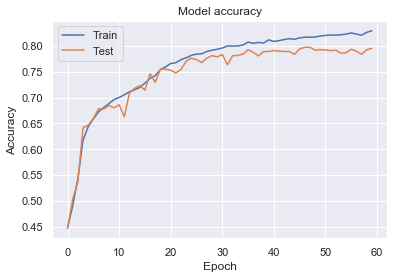

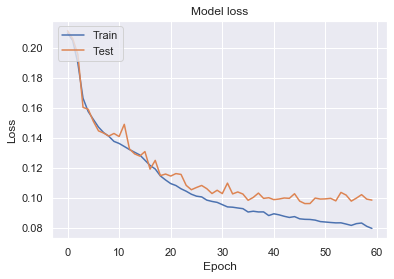

In [16]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
X_predict = model.predict(X_test)

In [18]:
X_predict_round = X_predict

for i in range(len(X_predict_round)):
    if X_predict_round[i][rows-1][0] == X_predict[i][rows-1].max():
        X_predict_round[i][rows-1] = [1,0,0]
    elif X_predict_round[i][rows-1][1] == X_predict[i][rows-1].max():
        X_predict_round[i][rows-1] = [0,1,0]
    elif X_predict_round[i][rows-1][2] == X_predict[i][rows-1].max():
        X_predict_round[i][rows-1] = [0,0,1]

In [19]:
accuracy = np.empty(len(y_test))

for i in range(len(X_predict_round)):
    if np.array_equal(X_predict_round[i][rows-1], y_test[i][rows-1]):
        accuracy[i] = True
    else:
        accuracy[i] = False
        
score_hs = round(np.mean(accuracy), 2)
 
print('Accuracy: ' + str(score_hs) + '%')

Accuracy: 0.91%


#### Predicting the nº of people

In [20]:
y = np.zeros((df_full_daily['no_people'].shape[0], 4))

for i in range(len(df_full_daily['no_people'])):
    if df_full_daily['no_people'][i] == 1:
        y[i] = [1,0,0,0]
    elif df_full_daily['no_people'][i] == 2:
        y[i] = [0,1,0,0]
    elif df_full_daily['no_people'][i] == 3:
        y[i] = [0,0,1,0]
    else:
        y[i] = [0,0,0,1]

print(X.shape)
print(y.shape)

(14891, 27, 12)
(402057, 4)


In [21]:
y = y.reshape(samples, rows, y.shape[1])
y.shape

(14891, 27, 4)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = Sequential()

# Recurrent layer
model.add(LSTM(60, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))

# Fully connected layer
model.add(Dropout(0.20))
model.add(Dense(20, activation='relu')) #relu/linear

# Output layer
model.add(Dense(4, activation='softmax')) #softmax/softmax para cada tipo de neurona

In [23]:
opt = adam(lr=0.01) #0.01

model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [24]:
y_train = y_train.astype(int)

history = model.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test))

Train on 10423 samples, validate on 4468 samples
Epoch 1/100
10423/10423 [==============================] - 10s 964us/step - loss: 0.5096 - acc: 0.7496 - val_loss: 0.5081 - val_acc: 0.7500
Epoch 2/100
10423/10423 [==============================] - 10s 914us/step - loss: 0.5075 - acc: 0.7500 - val_loss: 0.5078 - val_acc: 0.7500
Epoch 3/100
10423/10423 [==============================] - 10s 929us/step - loss: 0.5068 - acc: 0.7500 - val_loss: 0.5064 - val_acc: 0.7502
Epoch 4/100
10423/10423 [==============================] - 10s 922us/step - loss: 0.5061 - acc: 0.7500 - val_loss: 0.5038 - val_acc: 0.7501
Epoch 5/100
10423/10423 [==============================] - 9s 910us/step - loss: 0.5050 - acc: 0.7499 - val_loss: 0.5021 - val_acc: 0.7504
Epoch 6/100
10423/10423 [==============================] - 9s 908us/step - loss: 0.5002 - acc: 0.7511 - val_loss: 0.4953 - val_acc: 0.7543
Epoch 7/100
10423/10423 [==============================] - 10s 920us/step - loss: 0.4967 - acc: 0.7526 - val_loss

Epoch 59/100
10423/10423 [==============================] - 10s 923us/step - loss: 0.3841 - acc: 0.8213 - val_loss: 0.4658 - val_acc: 0.7920
Epoch 60/100
10423/10423 [==============================] - 9s 888us/step - loss: 0.3890 - acc: 0.8182 - val_loss: 0.4505 - val_acc: 0.7920
Epoch 61/100
10423/10423 [==============================] - 10s 923us/step - loss: 0.3814 - acc: 0.8226 - val_loss: 0.4482 - val_acc: 0.7944
Epoch 62/100
10423/10423 [==============================] - 9s 911us/step - loss: 0.3844 - acc: 0.8211 - val_loss: 0.4529 - val_acc: 0.7896
Epoch 63/100
10423/10423 [==============================] - 10s 921us/step - loss: 0.3804 - acc: 0.8234 - val_loss: 0.4664 - val_acc: 0.7935
Epoch 64/100
10423/10423 [==============================] - 10s 926us/step - loss: 0.3877 - acc: 0.8193 - val_loss: 0.4539 - val_acc: 0.7879
Epoch 65/100
10423/10423 [==============================] - 10s 917us/step - loss: 0.3864 - acc: 0.8201 - val_loss: 0.4473 - val_acc: 0.7948
Epoch 66/100
10

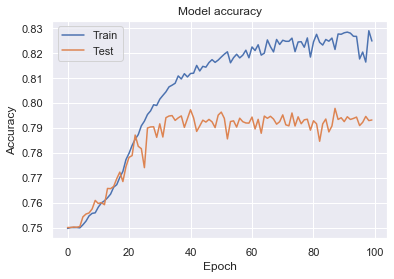

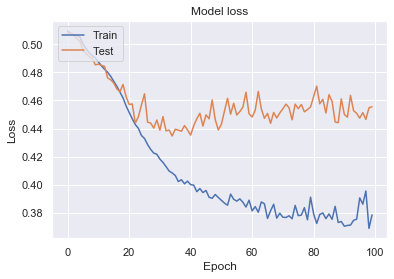

In [25]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [26]:
X_predict = model.predict(X_test)

In [27]:
X_predict_round = X_predict

for i in range(len(X_predict_round)):
    if X_predict_round[i][rows-1][0] == X_predict[i][rows-1].max():
        X_predict_round[i][rows-1] = [1,0,0,0]
    elif X_predict_round[i][rows-1][1] == X_predict[i][rows-1].max():
        X_predict_round[i][rows-1] = [0,1,0,0]
    elif X_predict_round[i][rows-1][2] == X_predict[i][rows-1].max():
        X_predict_round[i][rows-1] = [0,0,1,0]
    elif X_predict_round[i][rows-1][3] == X_predict[i][rows-1].max():
        X_predict_round[i][rows-1] = [0,0,0,1]

In [28]:
accuracy = np.empty(len(y_test))

for i in range(len(X_predict_round)):
    if np.array_equal(X_predict_round[i][rows-1], y_test[i][rows-1]):
        accuracy[i] = True
    else:
        accuracy[i] = False

score_pe = round(np.mean(accuracy), 2)
 
print('Accuracy: ' + str(score_pe) + '%')

Accuracy: 0.64%


#### Predicting the nº of solar panels

In [29]:
y = np.zeros((df_full_daily['sp_group'].shape[0], 3))

for i in range(len(df_full_daily['sp_group'])):
    if df_full_daily['sp_group'][i] == 1:
        y[i] = [1,0,0]
    elif df_full_daily['sp_group'][i] == 2:
        y[i] = [0,1,0]
    else:
        y[i] = [0,0,1]
        
print(X.shape)
print(y.shape)

(14891, 27, 12)
(402057, 3)


In [30]:
y = y.reshape(samples, rows, y.shape[1])
y.shape

(14891, 27, 3)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = Sequential()

# Recurrent layer
model.add(LSTM(40, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))

# Fully connected layer
model.add(Dropout(0.20))
model.add(Dense(20, activation='relu')) #relu/linear

# Output layer
model.add(Dense(3, activation='softmax')) #softmax/softmax para cada tipo de neurona

In [32]:
opt = adam(lr=0.003) #0.01

model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [33]:
y_train = y_train.astype(int)

history = model.fit(X_train, y_train, epochs = 50, validation_data=(X_test, y_test))

Train on 10423 samples, validate on 4468 samples
Epoch 1/50
10423/10423 [==============================] - 10s 968us/step - loss: 0.6244 - acc: 0.6678 - val_loss: 0.6143 - val_acc: 0.6669
Epoch 2/50
10423/10423 [==============================] - 9s 900us/step - loss: 0.6075 - acc: 0.6727 - val_loss: 0.6451 - val_acc: 0.6512
Epoch 3/50
10423/10423 [==============================] - 9s 860us/step - loss: 0.5984 - acc: 0.6778 - val_loss: 0.5838 - val_acc: 0.6874
Epoch 4/50
10423/10423 [==============================] - 9s 909us/step - loss: 0.5884 - acc: 0.6865 - val_loss: 0.6045 - val_acc: 0.6775
Epoch 5/50
10423/10423 [==============================] - 10s 926us/step - loss: 0.5819 - acc: 0.6920 - val_loss: 0.5818 - val_acc: 0.6918
Epoch 6/50
10423/10423 [==============================] - 10s 919us/step - loss: 0.5781 - acc: 0.6954 - val_loss: 0.5645 - val_acc: 0.7011
Epoch 7/50
10423/10423 [==============================] - 10s 921us/step - loss: 0.5709 - acc: 0.7011 - val_loss: 0.5614

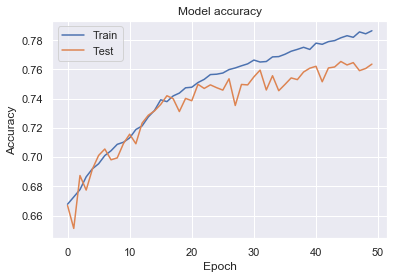

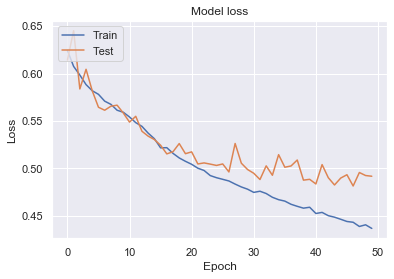

In [34]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [35]:
X_predict = model.predict(X_test)

In [36]:
X_predict_round = X_predict

for i in range(len(X_predict_round)):
    if X_predict_round[i][rows-1][0] == X_predict[i][rows-1].max():
        X_predict_round[i][rows-1] = [1,0,0]
    elif X_predict_round[i][rows-1][1] == X_predict[i][rows-1].max():
        X_predict_round[i][rows-1] = [0,1,0]
    else:
        X_predict_round[i][rows-1] = [0,0,1]

In [37]:
accuracy = np.empty(len(y_test))

for i in range(len(X_predict_round)):
    if np.array_equal(X_predict_round[i][rows-1], y_test[i][rows-1]):
        accuracy[i] = True
    else:
        accuracy[i] = False

score_sp = round(np.mean(accuracy), 2)
 
print('Accuracy: ' + str(score_sp) + '%')

Accuracy: 0.73%


## Model scores

In [38]:
lstm_scores = pd.DataFrame({'target': ['Heating system', 'Nº of people', 'Nº of solar panels'],
                          'score': [score_hs, score_pe, score_sp]})

Text(0.5, 0, 'Target')

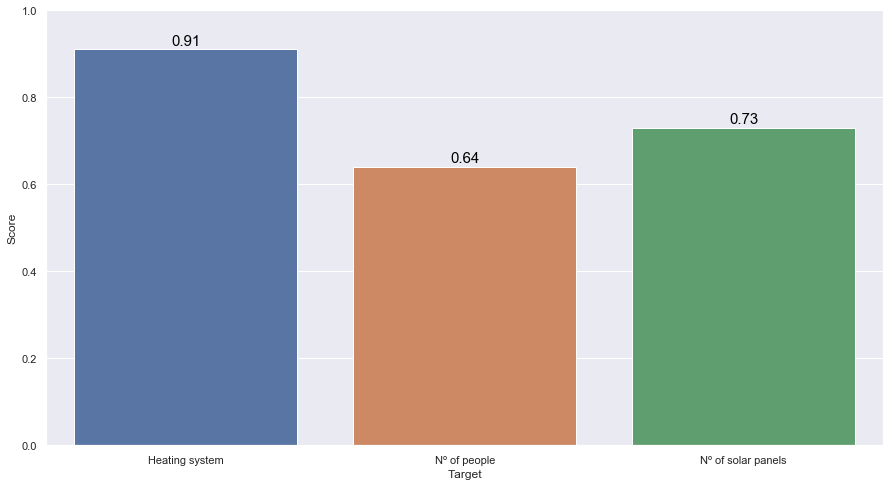

In [39]:
fig = plt.figure(figsize=(15,8))
ax = sns.barplot(x="target", y="score", data=lstm_scores)

for index, row in lstm_scores.iterrows():
    ax.text(index, (row.score + 0.01), round(row.score, 2), color='black', ha="center", fontsize=15)

ax.set_ylim(0,1)
ax.set_ylabel('Score')
ax.set_xlabel('Target')